# 一、包导入

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.16.2
pandas 0.25.3
sklearn 0.22.2.post1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


# 基本步骤
- 1. 预处理数据
- 2. 建立模型
- 2.1 encoder 
- 2.2 attention
- 2.3 decoder
- 3. evaluation 
- 3.1 given sentence, return translation results 
- 3.2 visualize results (attention)

# 二、数据预处理

##### unicode -> ascii

In [2]:
import unicodedata 
def unicode_to_ascii(s): # 处理了一下西班牙语(移除重音accent), 而且ascii好像大小比较小. 
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')  


# 举了个例子:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

May I borrow this book?
¿Puedo tomar prestado este libro?


##### 数据预处理

In [3]:
import re 
def preprocess_sentence(w):
    # 先变成 ASCII码. 
    w = unicode_to_ascii(w.lower().strip())

    # 标点符号前后加空格. 
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    # 多余的空格变成一个空格. 
    w = re.sub(r'[" "]+', " ", w)

    # 除了标点符号和字母外都替换为空格. 
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    # 去掉前后空格, rstrip表示去掉尾部空格. strip表示去掉头部空格. 
    w = w.rstrip().strip()

    w = '<start> ' + w + ' <end>'
    return w

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


##### 文本中读取数据

In [4]:
data_path = './spa.txt'

# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    # 按行分割. 
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    # 形成句子对 [['英语', '西班牙语']] 
    sentence_pairs = [line.split('\t') for line in lines]
    
    # 形成句子对 tuple [('英语', '西班牙语'), ('英语', '西班牙语')] 
    preprocessed_sentence_pairs = [
        (preprocess_sentence(en), preprocess_sentence(sp)) for en, sp in sentence_pairs]
    
    # 对每一行中的 两个句子 做预处理操作. 
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    # 将[('good', 1), ('bad', -1), ('thx', 1)] 变为 ('good', 'bad', 'thx') 和 (1, -1, 1) 两个tuple类型
    return zip(*word_pairs)

en_dataset, sp_dataset = create_dataset(data_path, None)
print(en[-1])
print(sp[-1])

NameError: name 'en' is not defined

In [ ]:
a = [(1, 2), (3, 4), (5, 6)]
c, d = zip(*a)
print(type(c))
print(c, d)

In [ ]:
a = [[1, 2], [3, 4], [5, 6]]
c, d = zip(*a)
print(type(c))
print(c, d)

##### 文本变数字序列. 

In [6]:
def tokenizer(lang):
    # num_words=None 代表对词表大小无要求.  filters='' 表示过滤也无要求. 按空格' '分割. 
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=None, filters='', split=' ') 
    
    # 拟合文本. 
    lang_tokenizer.fit_on_texts(lang)
    
    # 序列化后的文本. 
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    # 对序列化后的文本作下padding. 
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    # 返回序列化后的文本, 和tokenizer分割器. 
    return tensor, lang_tokenizer

# 看下 tensor的最大长度. 
def max_length(tensor):
    return max(len(t) for t in tensor)

input_tensor, input_tokenizer = tokenizer(sp_dataset[0:30000])
output_tensor, output_tokenizer = tokenizer(en_dataset[0:30000])

# 实验. 
max_length_input = max_length(input_tensor) 
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

16 11


##### 验证集和训练集的切分

In [7]:
from sklearn.model_selection import train_test_split 

# 训练集和测试集切分 8:2
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, output_tensor, test_size=0.2)

# 显示长度
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [8]:
input_tensor_train

array([[   1,    8,    7, ...,    0,    0,    0],
       [   1,    6,   43, ...,    0,    0,    0],
       [   1,  775,   31, ...,    0,    0,    0],
       ...,
       [   1,    7, 4167, ...,    0,    0,    0],
       [   1, 3473,   31, ...,    0,    0,    0],
       [   1,   12,  153, ...,    0,    0,    0]])

##### tf.data.Dataset 创建

In [14]:
def make_dataset(input_tensor, output_tensor, 
                 batch_size, epochs, shuffle):
    
    # 用了tf.data.Dataset. 
    dataset = tf.data.Dataset.from_tensor_slices(
        (input_tensor, output_tensor)) 
    
    # 如果需要打乱的话
    if shuffle: 
        dataset = dataset.shuffle(30000)
    
    
    # repeat 数据重复了 epochs 份.     
    # drop_remainder=True 代表. 如果大小不足一个batch_size, 丢弃. 
    dataset = dataset.repeat(epochs).batch(
        batch_size, drop_remainder = True)
    
    return dataset 

batch_size = 64 
epochs = 10 

train_dataset = make_dataset(
        input_tensor_train, target_tensor_train, batch_size, epochs, True)
eval_dataset = make_dataset(
        input_tensor_val, target_tensor_val, batch_size, 1, False)

In [15]:
# 随便取一个看看 shape 
for x, y in train_dataset.take(1):
    print(x.shape) 
    print(y.shape)
    
# [Batch_size, token_dim] 

(64, 16)
(64, 11)


# 三、模型建立

In [16]:
embedding_units = 256 
units = 1024 

# tokenizer.word_index 是 word -> index 的字典. 
input_vocab_size = len(input_tokenizer.word_index) + 1 
output_vocab_size = len(output_tokenizer.word_index) + 1 

##### 1、Encoder

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoding_units, batch_size):
        # 这里的 encoding_units 是 Encoder 输出每个token 的dimension.  
        
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        
        # embedding需要 词表大小vocab_size 和 输出维度embedding_dim 
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        
        # encoding_units代表      gru的time step. 
        # return_sequences=True代表      每步都输出output.  
        # return state=True代表          每步都输出hidden_state. 
        self.gru = keras.layers.GRU(self.encoding_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))

In [18]:
encoder = Encoder(input_vocab_size, embedding_units, 
                 units, batch_size)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)  # 这里的 x 是之前采的一个样本. 

print(x.shape)
print("sample_output.shape ", sample_output.shape)        # sample_output.shape = (64, 16, 1024) 这里的16代表一句话中有16个词.  
print("sample_hidden.shape ", sample_hidden.shape)

(64, 16)
sample_output.shape  (64, 16, 1024)
sample_hidden.shape  (64, 1024)


##### 2、BahdanauAttention

In [19]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):                  # 注意: 这里的units和下面call中的units是不同的，下面的是seq2seq的输出维度. 
                                                # 这里的units 只是 Dense后的units(好像可以随便设?) 
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)  # 和 encoder_outputs相乘. 
        self.W2 = tf.keras.layers.Dense(units)  # 和 decoder_hidden相乘. 
        self.V = tf.keras.layers.Dense(1)       # 和 tanh(W1*encoder_outputs + W2*decoder_hidden)相乘. 

        
    # attention中的一个输入是 decoder中上一个timestep传来的decoder_hidden. 
    # attention中的另一个输入是 encoder中所有timestep的输出outputs. 
    def call(self, decoder_hidden, encoder_outputs):
        # decoder_hidden.shape:  (batch_size, units) 需要拓展. 
        # encoder_hidden.shape:  (batch_size, length, units) 
        decoder_hidden_with_time_axis = tf.expand_dims(
            decoder_hidden, 1)
        
        # before V: (batch_size, length, units)
        # after  V: (batch_size, length, 1)   得到score. 每个timestep 一个 score.
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)))

        # attention_weights.shape :  (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector.shape :     (batch_size, length, units)
        # 计算: (batch_size, length, 1) * (batch_size, length, units) 只有最后一维对不上, tf 自动给做了padding.  
        context_vector = attention_weights * encoder_outputs 
        
        # context_vector.shape :     (batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [20]:
attention_model = BahdanauAttention(units = 10)
attention_results, attention_weights = attention_model(
    sample_hidden, sample_output)

# attention_results 是 context_vector. 
print("Attention result shape: (batch size, units) {}".format(attention_results.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


##### 3、decoder

In [21]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_units, 
                 decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units,          # decoder 每一time step的输出维度.  
                                    return_sequences=True,       # 同样需要每步都输出. 
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        # 全连接层. 
        self.fc = keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.decoding_units)

    def call(self, x, hidden, encoding_outputs):
        # x.shape: (Batchsize, 1)
        
        # context_vector.shape:  (batch_size, units)
        context_vector, attention_weights = self.attention(
            hidden, encoding_outputs)

        # before embedding:       x.shape: (batch_size, 1)
        # after embedding:        x.shape: (batch_size, 1, embedding_units) 
        x = self.embedding(x)

        # combined_x.shape:      (batch_size, 1, encoding_units + embedding_units)
        combined_x = tf.concat(
            [tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # output.shape:  (batch_size, 1, decoding_units)            疑问？为什么不是(batch_size, length, decoding_units)呢? 
        # state.shape :  (batch_size, decoding_units) 
        output, state = self.gru(combined_x)

        # output.shape : (batch_size , hidden_size) 去掉了shape中的1. 
        output = tf.reshape(output, (-1, output.shape[2]))

        # output.shape == (batch_size, vocab)  返回的是一个词. 
        output = self.fc(output)

        return output, state, attention_weights

In [22]:
decoder = Decoder(output_vocab_size, embedding_units,
                 units, batch_size)

outputs = decoder(tf.random.uniform((batch_size, 1)),
                 sample_hidden,
                 sample_output)

decoder_output, decoder_hidden, decoder_aw = outputs
# 输出的是某一时刻的单词,  4935是词表大小
print("decoder_output.shape: ", decoder_output.shape)
print("decoder_hidden.shape: ", decoder_hidden.shape)
print("decoder_attention_weights.shape: ", decoder_aw.shape)

decoder_output.shape:  (64, 4935)
decoder_hidden.shape:  (64, 1024)
decoder_attention_weights.shape:  (64, 16, 1)


# 四、损失函数

In [23]:
optimizer = keras.optimizers.Adam()

# from_logits 意思是 输出未经 softmax层,  reduction = 'none' 意思是不求取平均值
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = 'none')

# 这里只是单步（time_step）的损失函数。 
def loss_function(real, pred):
    # 这里的mask是为了遮挡. real中padding的部分, 因为padding部分不放在损失函数中
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    # before : mask元素是True or False. 
    # after  : mask元素是0 or 1 
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask 
    
    return tf.reduce_mean(loss_)

# 五、训练函数

##### 单步损失

In [24]:
# 添加tf.function 可以做加速. 
@tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0 
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(
            inp, encoding_hidden)
        
        # decoding 的初始 hidden 是 encoder的最后一个 hidden. 
        decoding_hidden = encoding_hidden 
        
        # eg: <start> I am here <end>
        # 1. <start> -> I
        # 2. I -> am 
        # 3. am -> here
        # 4. here -> <end>
        
        # decoding 有 (句长 - 1) 步. 
        for t in range(0, targ.shape[1] - 1):
            decoding_input = tf.expand_dims(targ[:, t], 1)
            
            predictions, decoding_hidden, _ = decoder(
                decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(targ[:, t+1], predictions) 
     
    
    batch_loss = loss / int(targ.shape[0]) 
    variables = encoder.trainable_variables + decoder.trainable_variables 
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss 

##### 开始训练

In [25]:
# epochs 是 整个数据集遍历 次数. 
# step_per_epoch. 是每个epoch 需要遍历 batch的个数
epochs = 10 
steps_per_epoch = len(input_tensor) // batch_size 

for epoch in range(epochs):
    start = time.time() 
    
    encoding_hidden = encoder.initialize_hidden_state() 
    total_loss = 0 
    
    for (batch, (inp, targ)) in enumerate(
        train_dataset.take(steps_per_epoch)):
        
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss 
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy()))
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                       total_loss / steps_per_epoch))
    print('Time take for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.8139
Epoch 1 Batch 100 Loss 0.3747
Epoch 1 Batch 200 Loss 0.3240
Epoch 1 Batch 300 Loss 0.3163
Epoch 1 Batch 400 Loss 0.2600
Epoch 1 Loss 0.3367
Time take for 1 epoch 83.3097403049469 sec

Epoch 2 Batch 0 Loss 0.2471
Epoch 2 Batch 100 Loss 0.2328
Epoch 2 Batch 200 Loss 0.2399
Epoch 2 Batch 300 Loss 0.2141
Epoch 2 Batch 400 Loss 0.1453
Epoch 2 Loss 0.2135
Time take for 1 epoch 69.20133399963379 sec

Epoch 3 Batch 0 Loss 0.1588
Epoch 3 Batch 100 Loss 0.1464
Epoch 3 Batch 200 Loss 0.1352
Epoch 3 Batch 300 Loss 0.1215
Epoch 3 Batch 400 Loss 0.1029
Epoch 3 Loss 0.1317
Time take for 1 epoch 68.0903377532959 sec

Epoch 4 Batch 0 Loss 0.0821
Epoch 4 Batch 100 Loss 0.0914
Epoch 4 Batch 200 Loss 0.0929
Epoch 4 Batch 300 Loss 0.0775
Epoch 4 Batch 400 Loss 0.0492
Epoch 4 Loss 0.0817
Time take for 1 epoch 67.2599892616272 sec

Epoch 5 Batch 0 Loss 0.0547
Epoch 5 Batch 100 Loss 0.0542
Epoch 5 Batch 200 Loss 0.0631
Epoch 5 Batch 300 Loss 0.0622
Epoch 5 Batch 400 Loss 0.0377
Epo

##### 模型的预测. 

In [32]:
# 单个句子的评估，如果batch个句子，需要修改 下面的 encoding_hidden 
def evaluate(input_sentence):
    # 注意力矩阵, 观察输入和输出之间的关系. 
    attention_matrix = np.zeros((max_length_output, max_length_input))
    # 预处理下句子. 
    input_sentence = preprocess_sentence(input_sentence)     
    
    
    inputs = [input_tokenizer.word_index[token] 
              for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
            [inputs], maxlen = max_length_input, padding = 'post') 
    # 转为tf.tensor类型
    inputs = tf.convert_to_tensor(inputs)
    
    
    results = '' 
    # encoding_hidden = encoder.initialize_hidden_state() 
    encoding_hidden = tf.zeros((1, units))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden 
    
    # eg: <start> -> A
    # A -> B -> C -> D
    
    # decoding_input.shape: (1, 1)
    decoding_input = tf.expand_dims(
        [output_tokenizer.word_index['<start>']], 0)
    
    for t in range(max_length_output):
        predictions, decoding_hidden, attention_weights = decoder(
            decoding_input, decoding_hidden, encoding_outputs)
        
        # attention_weights.shape: (batch_size, input_length, 1) -> (1, 16, 1) 
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_matrix[t] = attention_weights.numpy()
        
        # predictions.shape: (batch_size, vocab_size) (1, 4935)
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        results += output_tokenizer.index_word[predicted_id] + ' '
        
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence, attention_matrix 
        
        decoding_input = tf.expand_dims([predicted_id], 0)
    return results, input_sentence, attention_matrix     

In [37]:
def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    # cmap='viridis' 不同值 显示 不同颜色
    ax.matshow(attention_matrix, cmap='viridis')

    fontdict = {'fontsize': 14}
    # 最前面弄了个[''] 表示, 从第一个格子开始. 
    ax.set_xticklabels([''] + input_sentence, 
                       fontdict = fontdict, rotation = 90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()


def translate(input_sentence): 
    results, input_sentence, attention_matrix = evaluate(input_sentence)
    
    print("Input: %s" % (input_sentence))
    print("Predicted translation: %s" % (results))
    
    attention_matrix = attention_matrix[:len(results.split(' ')),
                                        :len(input_sentence.split(' '))]
    plot_attention(attention_matrix, input_sentence.split(' '),
                   results.split(' '))
    

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


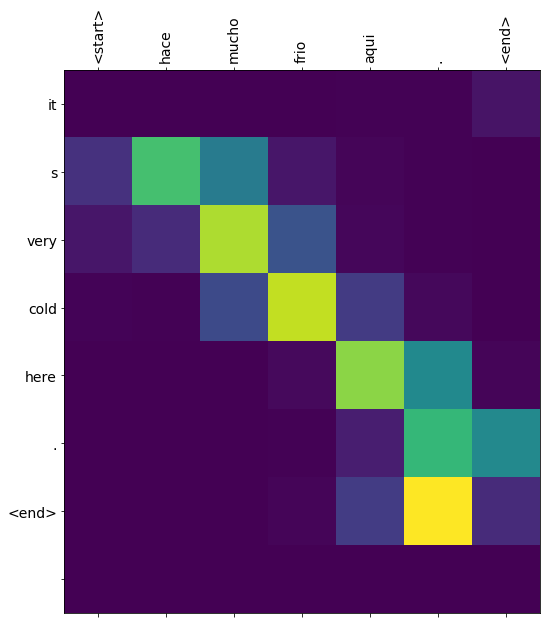

In [38]:
translate(u'Hace mucho frío aquí.')